Exploration of bagging, decision trees, random forests and grid search.
The provided examples should be helpful when setting up more specialised pipelines.

In [5]:
#Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
#Import data 
#The examples will focus on classification
data_wine=load_wine()

data=pd.DataFrame(data=data_wine.data,columns=data_wine.feature_names)
target=data_wine.target
target_names=data_wine.target_names

['class_0' 'class_1' 'class_2']
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453    

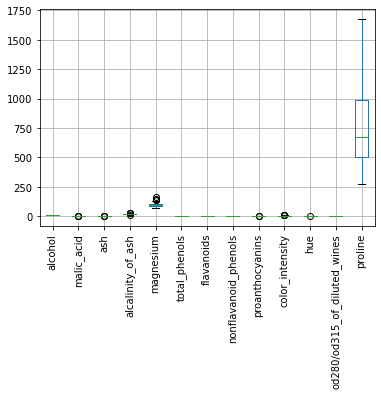

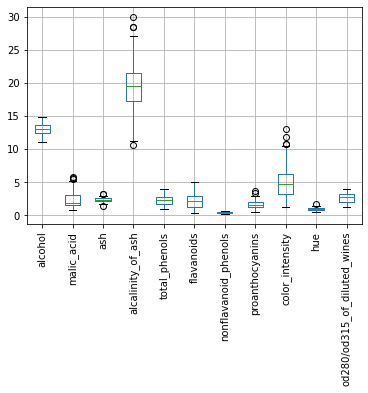

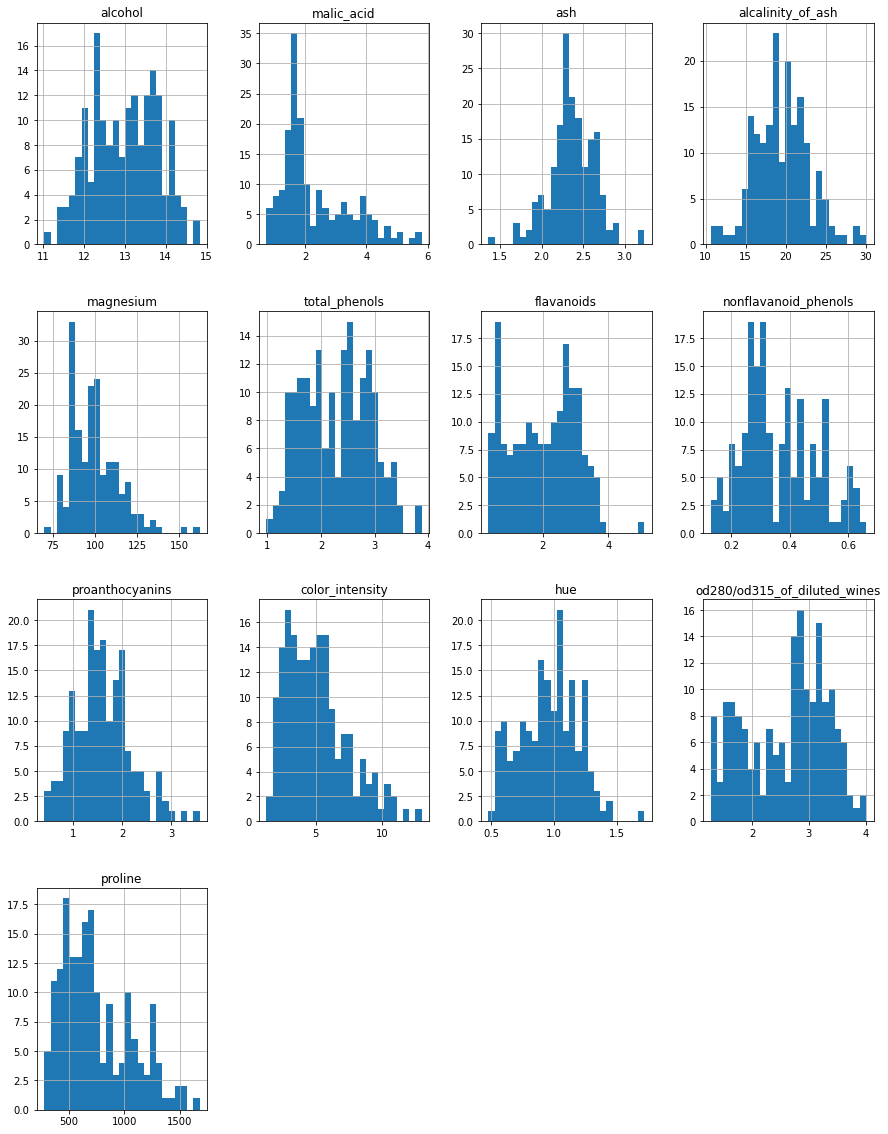

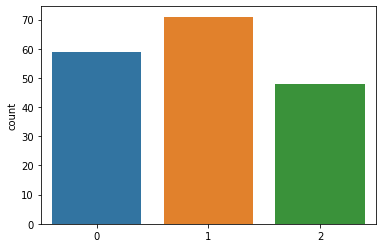

In [8]:
#Explore data 
print(target_names)

#Get descriptive statisctics
print(data.describe())
#Explore value distribution 
data.boxplot(rot=90)
plt.show()

#Explore value distribution without proline and magnesium
data.drop(columns=['proline','magnesium']).boxplot(rot=90)
plt.show()

#Explore feature distributions for potential outliers
data.hist(figsize=(15,20),bins=25)
plt.show()

#Assess target value counts  to evaluate if the data is balanced
sns.countplot(target)
plt.show()

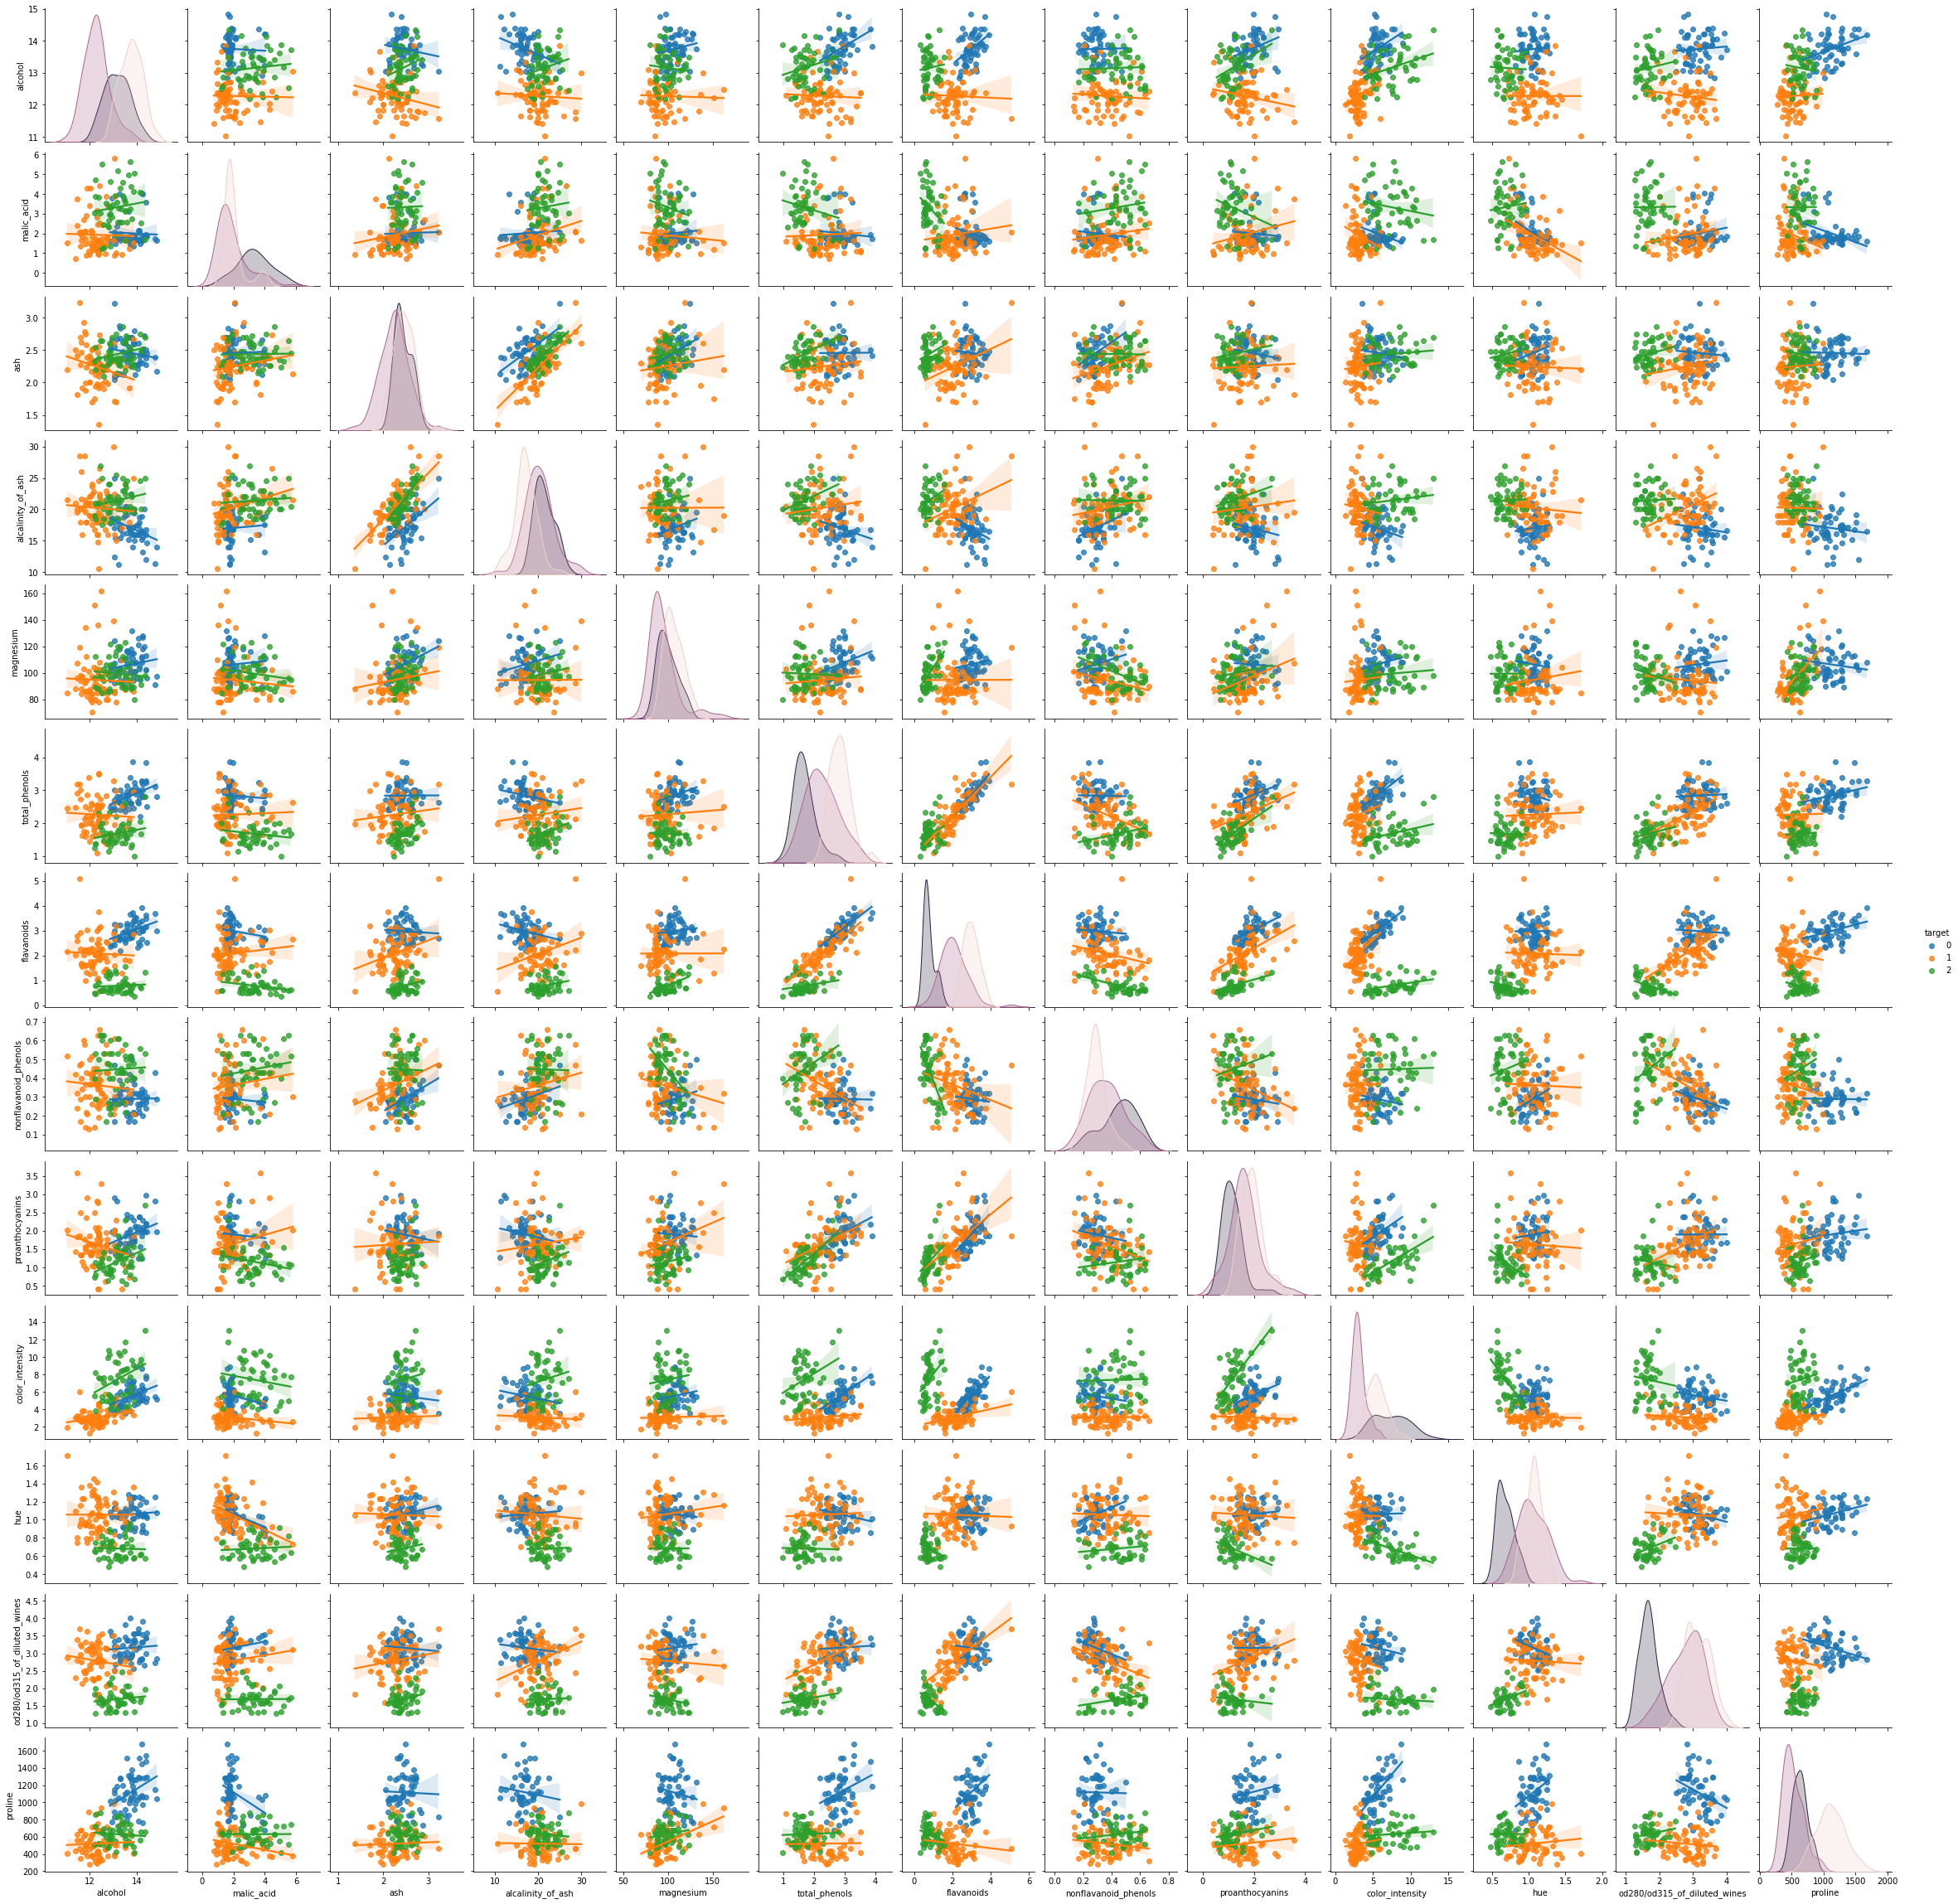

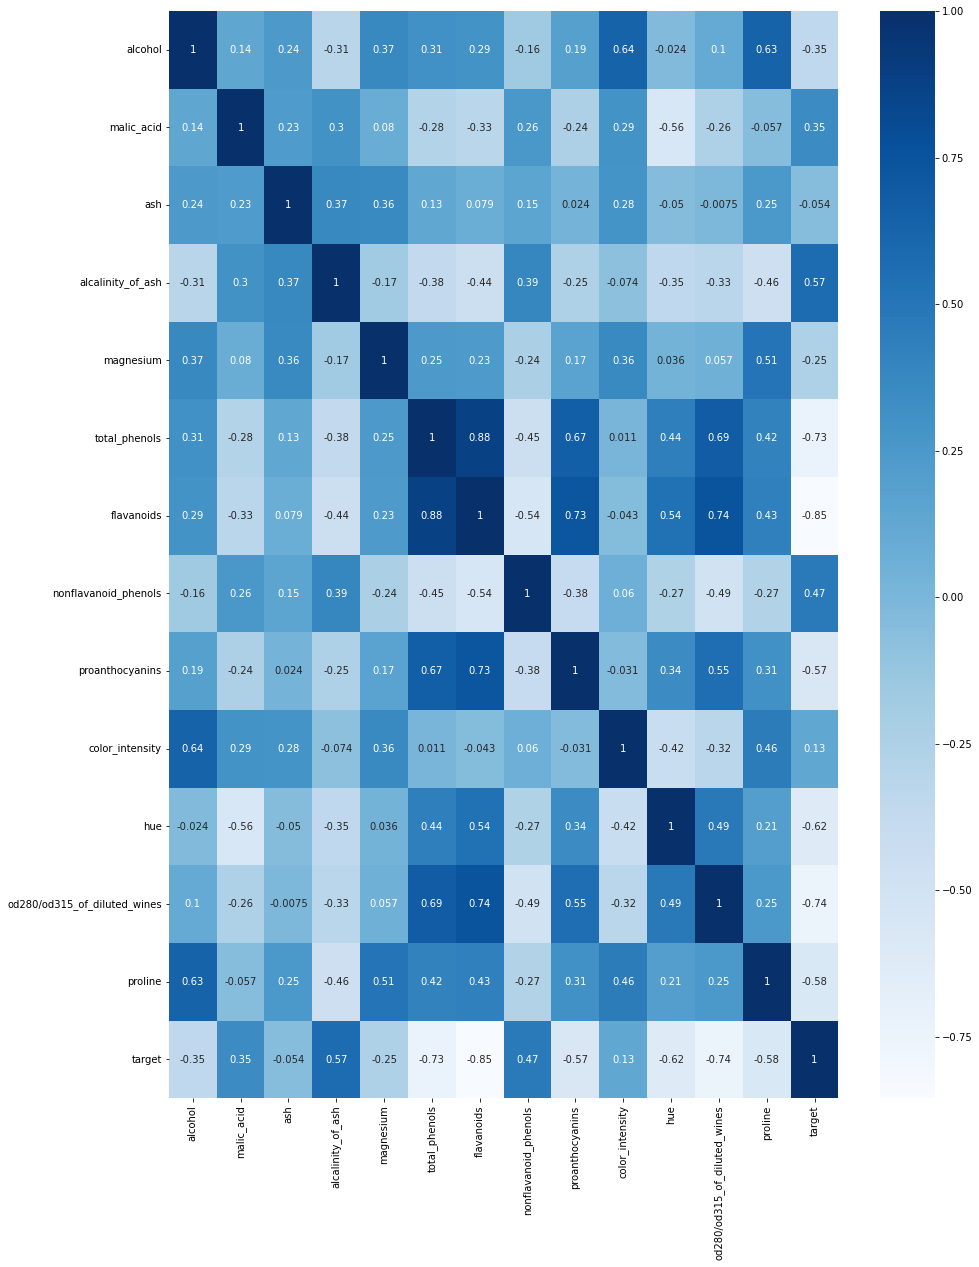

In [15]:
#Assess correlations
df=data.copy()
df['target']=target


sns.pairplot(df,hue='target',kind='reg',diag_kind='kde')
plt.show()

#Get value correlations
fig,ax=plt.subplots(figsize=(15,20))
sns.heatmap(df.corr(method='spearman'),annot=True,cmap='Blues')
plt.show()

In [25]:
#Explore if there are duplicate or missing values

print("Duplicated values {}".format(df.duplicated().sum()),"\n")

print("Missing values {}".format(df.isna().sum()),"\n")


Duplicated values 0 

Missing values alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64 



In [26]:
#Prepare data for modelling

#Split data
X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=0)

#Transform data
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [27]:
#Perform gridsearch for a decision tree classifier

cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=0)
params={'criterion':['gini','entropy'],'splitter':['best','random'],
'max_depth':[2,5,7,10,20],'max_features':[None,'sqrt','log2']}

model=DecisionTreeClassifier()

grid_search=RandomizedSearchCV(model,params,n_iter=50,scoring='accuracy',cv=cv,random_state=0)

grid_search.fit(X_train,y_train)

print("Best parameters",grid_search.best_params_,"\n")
print("Best score",grid_search.best_score_,"\n")

Best parameters {'splitter': 'best', 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini'} 

Best score 0.9435139573070607 



In [28]:
#Fit the best classifiier and crossvalidate

model=grid_search.best_estimator_

scores=cross_val_score(model,X_train,y_train,cv=cv)

print("Accuracy mean {} and std {}".format(scores.mean(),np.std(scores)))

Accuracy mean 0.8944991789819376 and std 0.04431140284360487


Classification report
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.88      0.93        16
           2       1.00      1.00      1.00         6

    accuracy                           0.94        36
   macro avg       0.96      0.96      0.96        36
weighted avg       0.95      0.94      0.94        36
 



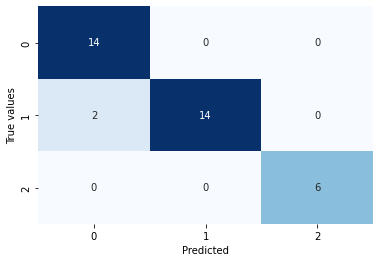

In [29]:
y_pred=model.predict(X_test)

print("Classification report\n",classification_report(y_test,y_pred),"\n")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g',cmap='Blues',cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True values")
plt.show()

In [30]:
#Perform gridsearch for bagging when using the decision tree classfiicer

cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=0)

params={'base_estimator__criterion':['gini','entropy'],'base_estimator__splitter':['best','random'],
'base_estimator__max_depth':[2,5,7,10,20],'base_estimator__max_features':[None,'sqrt','log2'],
 'n_estimators':[100,200,500,1000]}

model=DecisionTreeClassifier()
bg=BaggingClassifier(model)

grid_search=RandomizedSearchCV(bg,params,n_iter=50,scoring='accuracy',cv=cv,random_state=0)

grid_search.fit(X_train,y_train)

print("Best parameters",grid_search.best_params_,"\n")
print("Best score",grid_search.best_score_,"\n")

Best parameters {'n_estimators': 1000, 'base_estimator__splitter': 'best', 'base_estimator__max_features': 'sqrt', 'base_estimator__max_depth': 20, 'base_estimator__criterion': 'entropy'} 

Best score 0.9859605911330048 



Accuracy mean 0.9859605911330048 and std 0.01719910369467594
Classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        16
           2       0.86      1.00      0.92         6

    accuracy                           0.97        36
   macro avg       0.95      0.98      0.96        36
weighted avg       0.98      0.97      0.97        36
 



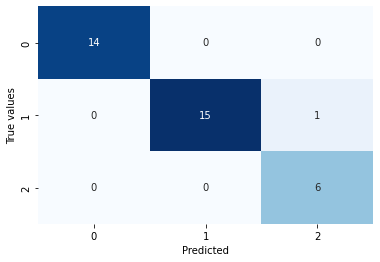

In [31]:
#Evaluate bagging

model=grid_search.best_estimator_

scores=cross_val_score(model,X_train,y_train,cv=cv)

print("Accuracy mean {} and std {}".format(scores.mean(),np.std(scores)))

y_pred=model.predict(X_test)

print("Classification report\n",classification_report(y_test,y_pred),"\n")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g',cmap='Blues',cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True values")
plt.show()

Accuracy mean 0.9835796387520525 and std 0.01755904095693222
Classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        16
           2       0.86      1.00      0.92         6

    accuracy                           0.97        36
   macro avg       0.95      0.98      0.96        36
weighted avg       0.98      0.97      0.97        36
 



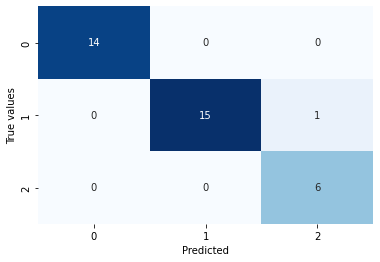

In [32]:
#Compare to random forests

rd=RandomForestClassifier(n_estimators=1000,max_depth=7)

rd.fit(X_train,y_train)

scores=cross_val_score(rd,X_train,y_train,cv=cv)

print("Accuracy mean {} and std {}".format(scores.mean(),np.std(scores)))

y_pred=rd.predict(X_test)

print("Classification report\n",classification_report(y_test,y_pred),"\n")
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g',cmap='Blues',cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True values")
plt.show()